# Load Data

Only Consider with:
- at least 8 games played
- at least 60 minutes played

In [105]:
import pandas as pd
import numpy as np
import seaborn as sns
import utils


MIN_GAMES_PLAYED = 8
MIN_MINUTES_PLAYED = 60


df_team_info_squad, df_team_info_opponent, df_squad_features, df_opponent_features = utils.load_team_statistics()
df_features, df_player_info = utils.load_player_statistics()

mask = (df_player_info["Matches Played"] > MIN_GAMES_PLAYED) & (df_player_info["Playing Time_Min"] > MIN_MINUTES_PLAYED)
player_info = df_player_info[mask]
df_features = df_features[mask]

adv_goalkeeping = ['Goals_GA', 'Goals_PKA', 'Goals_FK', 'Goals_CK', 'Goals_OG', 'PSxG',
       'PSxG/SoT', 'PSxG+/-', '/90', 'Launched_Cmp', 'Launched_Att',
       'Launched_Cmp%', 'Passes_Att', 'Passes_Thr', 'Passes_Launch%',
       'Passes_AvgLen', 'Goal Kicks_Att', 'Goal Kicks_Launch%',
       'Goal Kicks_AvgLen', 'Opp', 'Stp', 'Stp%', '#OPA', '#OPA/90',
       'AvgDist']
goalkeeping_cols = ['GA',
       'GA90', 'SoTA', 'Saves', 'Save%', 'W', 'D', 'L', 'CS', 'CS%',
       'Penalty Kicks_PKatt', 'Penalty Kicks_PKA', 'Penalty Kicks_PKsv',
       'Penalty Kicks_PKm', 'Penalty Kicks_Save%']
playing_time_cols = ['Playing Time_Minutes', 'Playing Time_Mn/MP','Starts', 'Mn/Start', 'Compl',
                     'Subs', 'unSub', 'PPM','onG', 'onGA','On-Off'
                    ]
col_to_drop = adv_goalkeeping + goalkeeping_cols + playing_time_cols

df_features = df_features.drop(columns = col_to_drop)
df_squad_features = df_squad_features.drop(columns=col_to_drop)
df_opponent_features = df_opponent_features.drop(columns=col_to_drop)

df_features.shape, df_squad_features.shape, df_opponent_features.shape


((2942, 86), (134, 86), (134, 86))

# Helper functions

In [177]:
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.cluster import KMeans

def plot_cluster_intertia(X, n_cluster=12):
    intertia = []
    for i in range(1,n_cluster):
        model = KMeans(n_clusters = i,init = "k-means++", max_iter = 300, n_init = 10, random_state = 42)
        model.fit(X)
        intertia.append(model.inertia_)


    plt.figure(figsize = (6,6))
    plt.plot(range(1,n_cluster), intertia, linewidth=2, markersize=6,marker='o',color = 'purple')
    plt.xticks(range(1,n_cluster))
    plt.xlabel("Number of clusters")
    plt.ylabel("Intertia")
    plt.show()

def create_3d_plot(data, labels, player_names):
    fig_3d = px.scatter_3d(
    data, x=0, y=1, z=2,
    color=labels,
    hover_name=player_names
    )
    fig_3d.update_traces(marker_size=2.5)
    fig_3d.show()

# Goal: Find a Team that matches with David Raum

__Player Profile__
- known for creating lots of chances by running along side and crosses into the penalty area, leading to many goals
- he is also a wing defender with fast pace

__Team Profile__
The team has to have the same kind of playing style meaning find a team that matches with the following data:
- Crosses, Crosses Into Penalty Area
- Comes along with clear Stricker that has many header attempts

__Challenge__:
- no heatmap
- no speed data

In [178]:
# Club with most crosses
df_squad_features["Crs"].sort_values(ascending=False) 

Team
Valencia         925.0
Athletic Club    918.0
Inter            885.0
Fiorentina       880.0
Sporting CP      843.0
                 ...  
Leverkusen       461.0
M'Gladbach       441.0
Lorient          434.0
Arouca           427.0
Paris S-G        399.0
Name: Crs, Length: 134, dtype: float64

In [179]:
print(f"Player avg: {df_features['Crs'].sort_values(ascending=False).mean()}")
print(f"Player median: {df_features['Crs'].sort_values(ascending=False).median()}")
print(f"David Raum: {df_features['Crs'].loc['David Raum']}")

Player avg: 28.622365737593473
Player median: 12.0
David Raum: 141.0


Without Scaling

In [180]:
from sklearn.metrics.pairwise import cosine_similarity

raum_features = df_features.loc["David Raum"].values.reshape(1, -1)  # Reshape to 2D (1, n_features)
similarities = cosine_similarity(raum_features, df_squad_features.values)

eval = pd.DataFrame({
    "Team": df_squad_features.index,
    "Sim": similarities.reshape(-1)
})

eval.sort_values("Sim",ascending=False)

,Team,Sim
116,Benfica,0.999161
4,Liverpool,0.998971
118,Braga,0.998851
80,Inter,0.998794
22,RB Leipzig,0.998689
...,...,...
59,Lens,0.988341
69,Montpellier,0.988337
68,Reims,0.988163
76,Troyes,0.987126


Test different Scaler: Team and Raum

In [181]:
from sklearn.preprocessing import StandardScaler, Normalizer,MinMaxScaler ,MaxAbsScaler,RobustScaler
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd

scalers = [StandardScaler(), Normalizer(),MinMaxScaler() ,MaxAbsScaler(),RobustScaler()]

for scaler in scalers:
    df_features_scaled = pd.DataFrame(scaler.fit_transform(df_features), index=df_features.index, columns=df_features.columns)
    df_squad_features_scaled = pd.DataFrame(scaler.fit_transform(df_squad_features), index=df_squad_features.index, columns=df_squad_features.columns)

    raum_features_scaled = df_features_scaled.loc["David Raum"].values.reshape(1, -1)
    similarities = cosine_similarity(raum_features_scaled, df_squad_features_scaled.values)

    eval = pd.DataFrame({
        "Team": df_squad_features_scaled.index,  # Club names
        "Sim": similarities.reshape(-1)  # Similarity scores reshaped to 1D array
    })

    eval.sort_values("Sim", ascending=False, inplace=True)
    print(scaler)
    print(eval)

StandardScaler()
              Team       Sim
85      Fiorentina  0.406200
45   Athletic Club  0.380292
73          Nantes  0.350284
80           Inter  0.319620
64            Lyon  0.309123
..             ...       ...
120         Arouca -0.323603
34        Augsburg -0.343745
32   Werder Bremen -0.352296
37      Hertha BSC -0.365064
31      Hoffenheim -0.378505

[134 rows x 2 columns]
Normalizer()
            Team       Sim
116      Benfica  0.999161
4      Liverpool  0.998971
118        Braga  0.998851
80         Inter  0.998794
22    RB Leipzig  0.998689
..           ...       ...
59          Lens  0.988341
69   Montpellier  0.988337
68         Reims  0.988163
76        Troyes  0.987126
67       Lorient  0.983617

[134 rows x 2 columns]
MinMaxScaler()
               Team       Sim
50       Celta Vigo  0.802203
11          Chelsea  0.801713
128  Gil Vicente FC  0.800258
66             Nice  0.792720
64             Lyon  0.791344
..              ...       ...
33           Bochum  0.53

__Thoughts__:
- StandardScaler() and MinMaxScaler() create a wider range 
- Normalizer() results to high sim for all + its creates sim results as without, because cosine normalizes as well

Test different Scaler: Raum vs other players 

In [182]:
from sklearn.preprocessing import StandardScaler, Normalizer,MinMaxScaler ,MaxAbsScaler,RobustScaler


scalers = [StandardScaler(), Normalizer(),MinMaxScaler() ,MaxAbsScaler(),RobustScaler()]

for scaler in scalers:
    df_scaled_features = pd.DataFrame(scaler.fit_transform(df_features), index=df_features.index, columns=df_features.columns)

    raum_features_scaled = df_scaled_features.loc["Christopher Nkunku"].values.reshape(1, -1)
    similarities = cosine_similarity(raum_features_scaled, df_scaled_features.drop(index="Christopher Nkunku").values)

    eval = pd.DataFrame({
        "Player": df_scaled_features.drop(index="Christopher Nkunku").index,
        "Sim": similarities.reshape(-1)
    })

    eval.sort_values("Sim", ascending=False, inplace=True)
    print(scaler)
    print(eval)


StandardScaler()
                   Player       Sim
2545           Rafa Silva  0.874409
566     Randal Kolo Muani  0.855003
1801      Ademola Lookman  0.842618
1489      Folarin Balogun  0.837686
1736        Ciro Immobile  0.834554
...                   ...       ...
327          Remo Freuler -0.617421
743   Ohis Felix Uduokhai -0.617749
2486       Julius Dirksen -0.620447
1435        Florent Ogier -0.627955
573       Kristijan Jakić -0.636371

[2941 rows x 2 columns]
Normalizer()
                 Player       Sim
841       Ferrán Torres  0.999340
2325       Rami Al Hajj  0.999273
536       Roland Sallai  0.999258
771         Enzo Millot  0.999248
203        Harry Wilson  0.999238
...                 ...       ...
2406     Anthony Musaba  0.840016
1571       Alberth Elis  0.815114
1356     Matthis Abline  0.722226
2046  Gabriel Strefezza  0.008497
1162     Hugo Guillamón  0.007044

[2941 rows x 2 columns]
MinMaxScaler()
                      Player       Sim
2545              Rafa Sil

In [183]:
# StandardScaler, RobustScaler, MinMaxScaler
print(eval[eval["Player"] == "Manuel Neuer"])
print(eval[eval["Player"] == "Dani Olmo"])
print(eval[eval["Player"] == "Konrad Laimer"])

           Player      Sim
454  Manuel Neuer -0.26575
        Player      Sim
498  Dani Olmo  0.71987
            Player       Sim
493  Konrad Laimer  0.295738


__Thoughts__:
<br>
- Here I get negative sim. compared to my cosine sim function
- The goalkeeper are not the least similar all the time which is weird 

Testing my cosine method

In [184]:
import utils

scalers = [StandardScaler(), Normalizer(),MinMaxScaler() ,MaxAbsScaler(),RobustScaler()]

for scaler in scalers:
    df_scaled_features = pd.DataFrame(scaler.fit_transform(df_features), index=df_features.index, columns=df_features.columns)

    q_player_idx = df_scaled_features.index.get_loc("Christopher Nkunku")
    eval= utils.get_top_k_similar_players(df_scaled_features, q_player_idx, player_info,top_k=2940)
    print(scaler)
    print(eval[["Player","cosine_similarity", "Global Pos"]])


StandardScaler()
                                  Player  cosine_similarity Global Pos
Player                                                                
Christopher Nkunku    Christopher Nkunku           1.000000         FW
Rafa Silva                    Rafa Silva           0.874409         MF
Randal Kolo Muani      Randal Kolo Muani           0.855003         FW
Ademola Lookman          Ademola Lookman           0.842618         FW
Folarin Balogun          Folarin Balogun           0.837686         FW
...                                  ...                ...        ...
Neraysho Kasanwirjo  Neraysho Kasanwirjo          -0.601836         DF
Nathaniel Clyne          Nathaniel Clyne          -0.615641         DF
Remo Freuler                Remo Freuler          -0.617421         MF
Ohis Felix Uduokhai  Ohis Felix Uduokhai          -0.617749         DF
Julius Dirksen            Julius Dirksen          -0.620447         DF

[2940 rows x 3 columns]
Normalizer()
                      

My Cosine function has not the exact same numbers. There are notable differences but its the same picture 

__Compare to defenders of the team.__
<br>
Assumption:
Current player match the playing style of a team. If similar player are already in a team than they the qualities of David Raum are played currently

In [185]:
from sklearn.preprocessing import StandardScaler, Normalizer,MinMaxScaler ,MaxAbsScaler,RobustScaler
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd

scalers = [StandardScaler(), Normalizer(),MinMaxScaler(),MaxAbsScaler(),RobustScaler()]

for scaler in scalers:
    df_features_scaled = pd.DataFrame(scaler.fit_transform(df_features), index=df_features.index, columns=df_features.columns)
    df_squad_features_scaled = pd.DataFrame(scaler.fit_transform(df_squad_features), index=df_squad_features.index, columns=df_squad_features.columns)

    raum_features_scaled = df_features_scaled.loc["David Raum"].values.reshape(1, -1)
    similarities = cosine_similarity(raum_features_scaled, df_squad_features_scaled.values)

    eval = pd.DataFrame({
        "Team": df_squad_features_scaled.index,  # Club names
        "Sim": similarities.reshape(-1)  # Similarity scores reshaped to 1D array
    })

    eval.sort_values("Sim", ascending=False, inplace=True)
    print(scaler)
    print(eval)
    

StandardScaler()
              Team       Sim
85      Fiorentina  0.406200
45   Athletic Club  0.380292
73          Nantes  0.350284
80           Inter  0.319620
64            Lyon  0.309123
..             ...       ...
120         Arouca -0.323603
34        Augsburg -0.343745
32   Werder Bremen -0.352296
37      Hertha BSC -0.365064
31      Hoffenheim -0.378505

[134 rows x 2 columns]
Normalizer()
            Team       Sim
116      Benfica  0.999161
4      Liverpool  0.998971
118        Braga  0.998851
80         Inter  0.998794
22    RB Leipzig  0.998689
..           ...       ...
59          Lens  0.988341
69   Montpellier  0.988337
68         Reims  0.988163
76        Troyes  0.987126
67       Lorient  0.983617

[134 rows x 2 columns]
MinMaxScaler()
               Team       Sim
50       Celta Vigo  0.802203
11          Chelsea  0.801713
128  Gil Vicente FC  0.800258
66             Nice  0.792720
64             Lyon  0.791344
..              ...       ...
33           Bochum  0.53

__Try__ Dimensionality Reduction and then Cosine

In [186]:
from sklearn.preprocessing import StandardScaler, Normalizer,MinMaxScaler ,MaxAbsScaler,RobustScaler
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import PCA
import pandas as pd
from sklearn.pipeline import make_pipeline

scalers = [StandardScaler(), Normalizer(),MinMaxScaler() ,MaxAbsScaler(),RobustScaler()]
q_player_idx = player_info.index.get_loc("David Raum")

for scaler in scalers:
    pca = PCA(n_components=30)
    pipe = make_pipeline(scaler, pca)

    components_player = pipe.fit_transform(df_features)
    components_query_player = components_player[q_player_idx]

    components_squad = pipe.fit_transform(df_squad_features)

    
    similarities = cosine_similarity(components_query_player.reshape(1, -1), components_squad)

    eval = pd.DataFrame({
        "Team": df_team_info_squad.index,  # Club names
        "Sim": similarities.reshape(-1)  # Similarity scores reshaped to 1D array
    })

    eval = eval.sort_values("Sim",ascending=False)

    print(scaler)
    print(eval)
    

StandardScaler()
              Team       Sim
7        Tottenham  0.581310
20   Bayern Munich  0.536845
58       Paris S-G  0.474658
1          Arsenal  0.470874
3    Newcastle Utd  0.447107
..             ...       ...
75         Ajaccio -0.477311
124       Boavista -0.480786
132          Paços -0.503000
44         Osasuna -0.543864
52          Getafe -0.609677

[134 rows x 2 columns]
Normalizer()
             Team       Sim
108  Go Ahead Eag  0.981306
56       Espanyol  0.979129
36     Schalke 04  0.976953
34       Augsburg  0.974390
46       Mallorca  0.973408
..            ...       ...
81          Milan -0.905431
98      Feyenoord -0.914510
38      Barcelona -0.935128
39    Real Madrid -0.943040
102        Twente -0.954616

[134 rows x 2 columns]
MinMaxScaler()
                Team       Sim
101       AZ Alkmaar  0.558552
98         Feyenoord  0.505032
102           Twente  0.483831
60         Marseille  0.478727
1            Arsenal  0.444738
..               ...       ...
132   

__Conclusion__:
Best and worst have equal number of crosses and crosses into penalty area.

- be more fine-grained with features

## Categorize teams

__Cluster__:
Now in this step, I want to investigate use clustering in order to categorize in different playing styles and their behaviour. We look at:
<br>
- defending
- possession
- passing
- goal and shot creation
- shooting

#### defending

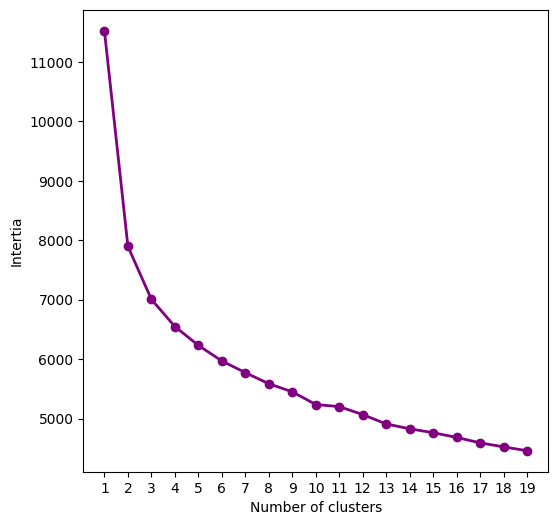

In [194]:
def_cols = ['Tackles_Def 3rd', 'Tackles_Mid 3rd','Tackles_Att 3rd']

df_squad_features_scaled = StandardScaler().fit_transform(df_squad_features)

plot_cluster_intertia(df_squad_features_scaled, n_cluster=20)

<Axes: ylabel='count'>

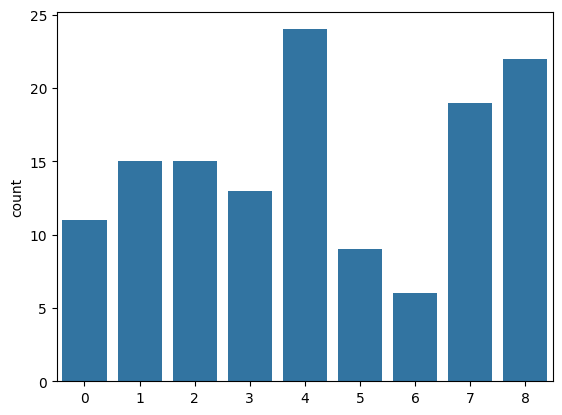

In [226]:
model = KMeans(n_clusters = 9, init = "k-means++", max_iter = 300, n_init = 12, random_state = 42)
labels = model.fit_predict(df_squad_features_scaled)

sns.countplot(x=np.array(labels))

In [227]:
eval = pd.DataFrame({
    'Labels': labels,
    "Team" : df_team_info_squad["Team"],
    "Tackles_Def 3rd": df_squad_features["Tackles_Def 3rd"],
    "Tackles_Mid 3rd": df_squad_features["Tackles_Mid 3rd"],
    "Tackles_Att 3rd": df_squad_features["Tackles_Att 3rd"]
})
eval.sort_values("Tackles_Att 3rd",ascending=False).head(20)

,Labels,Team,Tackles_Def 3rd,Tackles_Mid 3rd,Tackles_Att 3rd
Team,,,,,
Lyon,3,Lyon,306.0,282.0,135.0
Leeds United,8,Leeds United,376.0,343.0,121.0
Arsenal,6,Arsenal,238.0,212.0,118.0
Benfica,3,Benfica,243.0,305.0,112.0
Liverpool,3,Liverpool,228.0,250.0,112.0
Chelsea,5,Chelsea,363.0,267.0,110.0
Marseille,3,Marseille,271.0,304.0,110.0
Nice,3,Nice,415.0,295.0,108.0
Porto,2,Porto,251.0,234.0,108.0


In [231]:
fig_3d = px.scatter_3d(
    eval, 
    x='Tackles_Def 3rd', 
    y='Tackles_Mid 3rd', 
    z='Tackles_Att 3rd',
    color=eval["Labels"],           # Color by cluster or label
    hover_name=eval["Team"],        # Hover over teams
    title="3D Scatter of Tackles Across Thirds of the Field"
)
fig_3d.update_traces(marker_size=4)
fig_3d.show()

__Conclusion__:
<br>
Even though we anticipate obvious clusters, it is actually not

In [206]:

def_cols = ['Tackles_Def 3rd', 'Tackles_Mid 3rd','Tackles_Att 3rd']

possession_cols = ['Touches_Def Pen', 'Touches_Def 3rd',
       'Touches_Mid 3rd', 'Touches_Att 3rd', 'Touches_Att Pen','Take-Ons_Att', 'Carries_TotDist',
       'Carries_PrgDist', 'Carries_PrgC', 'Carries_1/3', 'Carries_CPA','Receiving_Succ', 'Receiving_PrgR'
        ]



### GPT: Euclidean, Cosine, Mahalanobis Distance
Mahalanobis Distance seems quite promising incombination with pca

In [207]:
import pandas as pd
from sklearn.preprocessing import StandardScaler,Normalizer
from sklearn.metrics.pairwise import euclidean_distances, cosine_similarity
from scipy.spatial.distance import mahalanobis
import numpy as np
from sklearn.decomposition import PCA

# Step 1: Normalize the data

def normalize_data(player_stats, team_stats, n_components=50):
    """
    Normalize player and team stats using Z-score normalization.
    """
    # Step 1: Normalize the data
    scaler = StandardScaler()
    
    # Fit the scaler on team stats to normalize both player and team stats on the same scale
    team_stats_normalized = scaler.fit_transform(team_stats)
    player_stats_normalized = scaler.transform([player_stats])  # We normalize the player stats separately but use the same scaler
    
    # Step 2: Apply PCA for dimensionality reduction
    pca = PCA(n_components=n_components)
    
    # Fit PCA on the team stats (since teams have more data) and transform both player and team stats
    team_stats_reduced = pca.fit_transform(team_stats_normalized)
    player_stats_reduced = pca.transform(player_stats_normalized)[0]  # We need only the transformed player stats array
    
    return player_stats_reduced, team_stats_reduced

# Step 2: Calculate Euclidean Distance and Cosine Similarity

def calculate_distances(player_stats_normalized, team_stats_normalized):
    """
    Calculate Euclidean distance and Cosine similarity between Player A's stats and each team's stats.
    """
    # Euclidean distance between player and teams
    euclidean_dist = euclidean_distances([player_stats_normalized], team_stats_normalized)[0]
    
    # Cosine similarity between player and teams
    cosine_sim = cosine_similarity([player_stats_normalized], team_stats_normalized)[0]

    # Covariance matrix of the team stats
    cov_matrix = np.cov(team_stats_normalized, rowvar=False)
    inv_cov_matrix = np.linalg.inv(cov_matrix)
    
    # Calculate Mahalanobis distance for each team
    maha_distances = [mahalanobis(player_stats_normalized, team, inv_cov_matrix) for team in team_stats_normalized]
    
    return euclidean_dist, cosine_sim, maha_distances

# Step 3: Rank Teams by Similarity

def rank_teams(euclidean_dist, cosine_sim, maha_distances, team_names):
    """
    Rank teams based on Euclidean distance, Cosine similarity, and Mahalanobis distance.
    
    Args:
        euclidean_dist (array): Euclidean distances between player and teams.
        cosine_sim (array): Cosine similarities between player and teams.
        maha_distances (array): Mahalanobis distances between player and teams.
        team_names (list): List of team names corresponding to the stats.
    
    Returns:
        pd.DataFrame: DataFrame containing teams, distances, similarities, and rankings.
    """
    # Create a DataFrame to store the results
    similarity_df = pd.DataFrame({
        'Team': team_names,
        'Euclidean_Distance': euclidean_dist,
        'Cosine_Similarity': cosine_sim,
        'Mahalanobis_Distance': maha_distances
    })
    
    # Rank teams by Euclidean distance (lower is more similar)
    similarity_df['Euclidean_Rank'] = similarity_df['Euclidean_Distance'].rank(method='min')
    
    # Rank teams by Mahalanobis distance (lower is more similar)
    similarity_df['Mahalanobis_Rank'] = similarity_df['Mahalanobis_Distance'].rank(method='min')
    
    # Rank teams by Cosine similarity (higher is better, so reverse the rank)
    similarity_df['Cosine_Rank'] = similarity_df['Cosine_Similarity'].rank(method='min', ascending=False)
    
    # Sort by the Euclidean distance first, but you can change the sorting based on your preference
    similarity_df = similarity_df.sort_values(by=['Euclidean_Distance', 'Cosine_Similarity','Mahalanobis_Distance']).reset_index(drop=True)
    
    return similarity_df


player = df_features.loc['Christopher Nkunku']

player_stats_normalized, team_stats_normalized = normalize_data(player, df_squad_features, n_components=13)

# Calculate distances
euclidean_dist, cosine_sim, mahalanobis = calculate_distances(player_stats_normalized, team_stats_normalized)

# Rank teams
ranked_teams = rank_teams(euclidean_dist, cosine_sim,mahalanobis, df_squad_features.index)

ranked_teams.head(50)

c:\Users\Alexander Lorenz\anaconda3\envs\ml\Lib\site-packages\sklearn\base.py:464: UserWarning:

X does not have valid feature names, but StandardScaler was fitted with feature names



,Team,Euclidean_Distance,Cosine_Similarity,Mahalanobis_Distance,Euclidean_Rank,Mahalanobis_Rank,Cosine_Rank
0,Augsburg,37.015849,0.640428,17.416599,1.0,15.0,10.0
1,Union Berlin,37.525753,0.653193,17.413159,2.0,14.0,8.0
2,Hertha BSC,37.534338,0.673995,16.760497,3.0,5.0,7.0
3,Estoril,37.656178,0.701172,17.167400,4.0,12.0,4.0
4,Boavista,37.709085,0.855834,15.849257,5.0,1.0,2.0
5,Vizela,37.731935,0.736640,16.424364,6.0,3.0,3.0
6,Freiburg,38.165347,0.694531,17.514725,7.0,21.0,6.0
7,Santa Clara,38.485762,0.583895,17.494827,8.0,20.0,16.0
8,Hoffenheim,38.901287,0.861488,17.024037,9.0,9.0,1.0
9,Paços,39.009604,0.573334,17.595301,10.0,24.0,19.0


first predict the best cluster for the player using Euclidean distance and then compute the Cosine similarity only for the teams within that predicted cluster.

The scaled, components have the same value range kind of

In [208]:
player_stats_reduced

NameError: name 'player_stats_reduced' is not defined

In [6]:
team_stats_reduced[:,0]

array([ 17.8956769 ,  11.54779714,   5.70155027,   5.48888721,
        11.85935654,  10.06765328,  -0.08902285,   3.51417981,
        -3.96223771,  -0.25482879,  -1.44267548,   5.37459051,
        -2.97765703,  -3.29578063,  -7.4791988 , -10.47685249,
        -6.02440992,  -2.17681776,  -4.31298591,  -5.8849563 ,
        14.89294534,   9.92094548,   6.31518238,  -5.05724956,
        -3.07832135,   1.93190343,   0.63320962,  -1.41354021,
        -5.86083428,  -0.22096508,  -2.92061858,  -4.04070215,
        -4.737393  , -11.15352439, -10.59581093,  -0.58754856,
        -9.43387715,  -9.5479362 ,  16.00117672,  16.09264473,
         5.7332445 ,   2.90114795,   6.76818541,  -0.69807344,
        -2.46462145,   3.85766834,  -7.5624691 ,   1.10841224,
        -0.46232567,   0.26149284,  -0.11298228,  -9.47615275,
        -9.83032573,   0.08119767,  -4.50203495,  -4.37541614,
        -6.00799836,  -6.30071332,  17.11940556,   9.60221557,
         8.17780894,   8.91670141,  10.78910018,   4.01